In [1]:
import pickle
import numpy as np
import pandas as pd
import pygeohash as pgh
import matplotlib.pyplot as plt
import reverse_geocoder as rg
from scipy.stats import entropy

import math

# import geopy.distance

from datetime import datetime
from pandarallel import pandarallel

pandarallel.initialize(nb_workers=4, progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Detecting Seasonal Patterns in User Movement

There is more to human movement than periodic patterns and social-based movement. While the paper accurately predicts human movement throughout the week, we propose a more all-encompassing analysis that paints a broader picture, exploring monthly and seasonal movement. To do so, we will use the original check-in and friendship datasets from Gowalla and Brightkite and separate them into subsets representing a narrower time of the year. We want to see what mobility patterns are exhibited in different countries and throughout different times of the year: users can go on vacation, travel abroad, and change homes. This would allow us to understand the travelling patterns of users around the world (i.e. who is more likely to travel and where) as well as the distribution of check-ins and their density. We want to produce visualizations showcasing these patterns on a world map. 

Our starting point is the first replication of the Friendship and Mobility paper. We re-use the data-loading and data cleaning part, as well as the technique to determine home locations.

## Loading the data

In [2]:
# The datasets have no headers, so we have to name them for clarity
checkin_header = ['user', 'checkin_time', 'latitude', 'longitude', 'location_id']
edges_header = ['user1', 'user2']

# Load the data by specifying the correct compression algorithm, separator and column names
checkin_brightkite_orig = pd.read_csv('data/loc-brightkite_totalCheckins.txt.gz', compression = 'gzip', sep = '\t', names = checkin_header)
edges_brightkite_orig = pd.read_csv('data/loc-brightkite_edges.txt.gz', compression = 'gzip', sep = '\t', names = edges_header)
checkin_gowalla_orig = pd.read_csv('data/loc-gowalla_totalCheckins.txt.gz', compression = 'gzip', sep = '\t', names = checkin_header)
edges_gowalla_orig = pd.read_csv('data/loc-gowalla_edges.txt.gz', compression = 'gzip', sep = '\t', names = edges_header)

## Cleaning the data

Some of the latitude and longitude values are not in the valid range of [-90, 90] and [-180, 180] respectively. Moreover, the location having (lat, long) = (0,0) is not a valid one . In both datasets, we remove rows in which either of the location attributes are not valid. We also remove the rows of the Brightkite dataset that have NaN values. 

In [6]:
def clean(checkins):
    """ Rids the check-in data of invalid coordinates """
    to_drop = []
    # Select indexes to drop depending on conditions mentionned above 
    to_drop.append(checkins[(checkins['latitude'] < -90.0) | 
                                   (checkins['latitude'] > 90.0)].index)
    to_drop.append(checkins[(checkins['longitude'] < -180.0) | 
                                   (checkins['longitude'] > 180.0)].index)
    to_drop.append(checkins[(checkins['latitude'] == 0) & 
                                   (checkins['longitude'] == 0)].index)
    
    for item in to_drop:
        checkins.drop(item, inplace = True)
    checkins.dropna(inplace = True)
    
    return checkins

In [4]:
# Pass copy of DataFrama in order not to have to reload the original one in case of a mistake
checkin_brightkite = clean(checkin_brightkite_orig.copy())
checkin_gowalla    = clean(checkin_gowalla_orig.copy())

## Adding country information to check-ins

For each check-in, we append the country code corresponding to the country the check-in was made in. This is done using a reverse geohashing library [`reverse_geocoder`](https://github.com/thampiman/reverse-geocoder) that maps coordinates (latitutde, longitude) to information about a specific place (e.g. city, country, country code).

In [7]:
def extract_coordinates(row):
    return (row['latitude'], row['longitude'])

def coordinates_to_country(df):
    """
        Maps the coordinates of a dataframe to the country
        code using reverse geocoding
    """
    coordinates_tuples = list(df.parallel_apply(extract_coordinates, axis = 1))
    geocodes = rg.search(coordinates_tuples)
    return [gc['cc'] for gc in geocodes]

In [6]:
# # Append country codes to each check-in for both datasets
checkin_brightkite['cc'] = coordinates_to_country(checkin_brightkite)
checkin_gowalla['cc']    = coordinates_to_country(checkin_gowalla)

checkin_brightkite.head()

Process ForkPoolWorker-15:
Process ForkPoolWorker-14:
Process ForkPoolWorker-11:
Process ForkPoolWorker-13:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-10:
  File "/home/karim/anaconda3/envs/ada/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Process ForkPoolWorker-12:
Process ForkPoolWorker-16:
  File "/home/karim/anaconda3/envs/ada/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Process ForkPoolWorker-17:
  File "/home/karim/anaconda3/envs/ada/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/karim/anaconda3/envs/ada/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/karim/anaconda3/envs/ada/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most

KeyboardInterrupt: 

## Determining the location of user homes

Here, the geohash is used to determine the home location for every user. Since this is similar to what was done in the replication, we will not go into detail about the implementation and justification.

In [8]:
def geohash_encode(row, precision = 4):
    """
        Computes and returns the geohash with 
        precision 4 for a given row 
    """
    return pgh.encode(*extract_coordinates(row), precision=precision)

def find_home_cell(checkins, user_id):
    """ Given a user id, finds the most common world cell """
    # Retrieve all the user's check-ins
    group = checkins[checkins['user']  == user_id]
    # Get the most common geohash for the user
    return group.groupby('geohash').size().idxmax()

def find_home(checkins, user_id):
    """
        Given a user id, finds the most common world cell and 
        computes average location to estimate home location
    """
    # Retrieve all the user's check-ins
    group = checkins[checkins['user']  == user_id]
    # Get the most common geohash for the user
    geohash = group.groupby('geohash').size().idxmax()
    
    # Keep all checkins that happened in the most common geohash and compute average position
    return group[group['geohash'] == geohash][['latitude', 'longitude']].mean()

In [ ]:
# Compute the geohash for each check-in entry: that will determine the cell in which each check-in belongs
checkin_brightkite['geohash'] = checkin_brightkite.parallel_apply(geohash_encode, axis = 1)
checkin_gowalla['geohash']    = checkin_gowalla.parallel_apply(geohash_encode, axis = 1)

In [ ]:
# All the users that made at least 1 check-in
brightkite_users = set(checkin_brightkite.user)
gowalla_users = set(checkin_gowalla.user)

# Create empty DataFrame with user ids and apply function to all users
brightkite_homes = pd.DataFrame(index = brightkite_users).index.to_series().parallel_apply(lambda user_id: find_home(checkin_brightkite, user_id)) 
gowalla_homes = pd.DataFrame(index = gowalla_users).index.to_series().parallel_apply(lambda user_id: find_home(checkin_gpwalla, user_id)) 

# Add the country codes to the homes
brightkite_homes['cc'] = coordinates_to_country(brightkite_homes)
gowalla_homes['cc'] = coordinates_to_country(gowalla_homes)

brightkite_homes.head()

## Adding temporal information to the check-in data

To be able to separate check-ins temporally, we add to each check-in, the month and season it was made in. 

In [9]:
def to_datetime(row):
    """ Returns the string found in the row to the correctly formatted datetime object """
    return datetime.strptime(row['checkin_time'], '%Y-%m-%dT%H:%M:%SZ')

def get_month(row):
    """ Extracts the month from the given row. """
    return to_datetime(row).month

def get_day(row):
    """ Extracts the day from the given row. """
    return to_datetime(row).weekday() # Monday is 0, Sunday is 6

def hour_of_week(row):
    """ Extracts the hour of the week. A week has 168 hours. """
    return to_datetime(row).weekday()*24 + to_datetime(row).hour

def get_season(row):
    """ 
        Returns the season from a certain row
        Adapted from https://stackoverflow.com/a/28688724 
    """
    date_time = to_datetime(row)
    date_time = date_time.replace(year=Y, hour=0, minute=0, second=0)
    
    # Define the datetime intervals according to every season
    Y = 2000 # Leap year to allow input X-02-29, which allows for leap days
    seasons = [('winter', (datetime(Y,  1,  1),  datetime(Y,  3, 20))),
               ('spring', (datetime(Y,  3, 21),  datetime(Y,  6, 20))),
               ('summer', (datetime(Y,  6, 21),  datetime(Y,  9, 22))),
               ('autumn', (datetime(Y,  9, 23),  datetime(Y, 12, 20))),
               ('winter', (datetime(Y, 12, 21),  datetime(Y, 12, 31)))]
    
    return next(season for season, (start, end) in seasons_periods if start <= date_time <= end)

seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
months = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',\
          7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

In [ ]:
# Find the month associated with every check-in
checkin_brightkite['month'] = checkin_brightkite.parallel_apply(get_month, axis=1)
checkin_gowalla['month'] = checkin_gowalla.parallel_apply(get_month, axis=1)

# Find the season associated with every check-in
checkin_brightkite['season'] = checkin_brightkite.parallel_apply(get_season, axis=1)
checkin_gowalla['season'] = checkin_gowalla.parallel_apply(get_season, axis=1)

# Find the day of week associated with every check-in
checkin_brightkite['day_of_week'] = checkin_brightkite.parallel_apply(day_of_week, axis=1)
checkin_gowalla['day_of_week'] = checkin_gowalla.parallel_apply(day_of_week, axis=1)

# Find the hour of week assoiated with every check-in (used for entropy) 
checkin_brightkite['hour_of_week'] = checkin_brightkite.parallel_apply(hour_of_week, axis=1)
checkin_gowalla['hour_of_week'] = checkin_gowalla.parallel_apply(hour_of_week, axis=1)

checkin_brightkite.head()

## Identify travelers

We now indentify users who travel. We define a traveler as a user who has made at least one check-in outside of his home country (determined by the country of its home location). 

In [10]:
def traveler_check(group):
    """ A user is a traveler if he has ever checked in to more than one country """
    return True if len(set(group['cc'])) > 1 else False

In [ ]:
# Find travellers in both datasets
brightkite_homes['is_traveler'] = checkin_brightkite.groupby('user').parallel_apply(traveler_check)
gowalla_homes['is_traveler'] = checkin_gowalla.groupby('user').parallel_apply(traveler_check)

brightkite_homes.head()

In [ ]:
# Store homes in dictionary for faster access
brightkite_homes = brightkite_homes.to_dict(orient = 'index')
gowalla_homes = gowalla_homes.to_dict(orient = 'index')

In [ ]:
checkin_brightkite['is_abroad'] = checkin_brightkite.parallel_apply(lambda row: row['cc'] != brightkite_homes[row['user']]['cc'], axis = 1)
checkin_gowalla['is_abroad'] = checkin_gowalla.parallel_apply(lambda row: row['cc'] != gowalla_homes[row['user']]['cc'], axis = 1)

**TODO**: add statistics on the data (i.e. where are travelers from)

## When are users more likely to travel ?

TODO

In [11]:
# Credits of the function implementation: https://stackoverflow.com/a/15737218
from math import radians, cos, sin, asin, sqrt
def haversine(lat1, lon1, lat2, lon2):
    """
        Calculates the great circle distance (in km) between two points 
        on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [12]:
def get_distance_from_home(row, homes):
    """ 
    calulate_home_distance_bk: calulates the distance between two lat/long coordinaes, which
                               in this case are the homes of two friends using the coordinates
                               in the bk_user_homes dataframe
    arg row: a row from the dataframe containingn friend data
    """  
    home_lat = homes[row['user']]['latitude']
    home_long = homes[row['user']]['longitude']

    return haversine(home_lat, home_long, row['latitude'], row['longitude'])

In [ ]:
checkin_brightkite['distance_from_home'] = checkin_brightkite.parallel_apply(lambda row: get_distance_from_home(row, brightkite_homes), axis=1)
checkin_gowalla['distance_from_home'] = checkin_gowalla.parallel_apply(lambda row: get_distance_from_home(row, gowalla_homes), axis=1)

In [ ]:
max_dist = math.log10(checkin_brightkite.distance_from_home.max())
checkin_brightkite[~checkin_brightkite['is_abroad']].distance_from_home.plot.kde(bw_method = 0.001, ind = np.logspace(0, max_dist, 50), loglog=True, 
                                                             ls = '', marker = 'o', fillstyle = 'none', color = 'blue')
checkin_brightkite[checkin_brightkite['is_abroad']].distance_from_home.plot.kde(bw_method = 0.001, ind = np.logspace(0, max_dist, 50), loglog=True, 
                                                             ls = '', marker = 'o', fillstyle = 'none', color = 'lightblue')

fig.tight_layout()
plt.ylim(10e-8, 10e0)
plt.legend(['Brightkite', 'Brightkite travelers', 'Gowalla', 'Gowalla travelers'])
plt.xlabel('Check-in distance from home (km)')
plt.show()
# [TODO] This is kinda obvious on second thought: if user travels to another country, distance traveled is clearly gonna be > 
# Wouldn't it make more sense to plot the distance from home of check-ins made aborad, vs regular ones ?

In [ ]:
fig, axs = plt.subplots(3, 4, figsize = (20, 10), sharex = True, sharey = True)
axs = axs.ravel()

max_dist = math.log10(checkin_brightkite.distance_from_home.max())

for i in range(0, 12):
    checkin_brightkite[(~checkin_brightkite['is_abroad']) & (checkin_brightkite['month'] == i+1)].distance_from_home.plot.kde(bw_method = 0.001, ind = np.logspace(0, max_dist, 30), loglog=True, 
                                                                 ls = '', marker = 'o', fillstyle = 'none', color = 'blue', ax = axs[i])
    checkin_brightkite[(checkin_brightkite['is_abroad']) & (checkin_brightkite['month'] == i+1)].distance_from_home.plot.kde(bw_method = 0.001, ind = np.logspace(0, max_dist, 30), loglog=True, 
                                                                 ls = '', marker = 'o', fillstyle = 'none', color = 'lightblue', ax = axs[i])
    
#     checkin_gowalla[(~checkin_gowalla['is_traveler']) & (checkin_gowalla['month'] == i+1)].distance_from_home.plot.kde(bw_method = 0.001, ind = np.logspace(0, max_dist, 20), loglog=True, 
#                                                                  ls = '', marker = 'o', fillstyle = 'none', color = 'red', ax = axs[i])
#     checkin_gowalla[(checkin_gowalla['is_traveler']) & (checkin_gowalla['month'] == i+1)].distance_from_home.plot.kde(bw_method = 0.001, ind = np.logspace(0, max_dist, 20), loglog=True, 
#                                                                  ls = '', marker = 'o', fillstyle = 'none', color = 'lightcoral', ax = axs[i])
    axs[i].title.set_text(months[i+1])

fig.tight_layout()
plt.ylim(10e-8, 10e0)
plt.legend(['Brightkite', 'Brightkite travelers', 'Gowalla', 'Gowalla travelers'])
fig.text(0.5, 0, 'Check-in distance from home (km)', ha='center')

plt.show()

**TODO** since the question is "when are users likely to travel", we can check when do check-ins to another country occur (i.e. travel) and see if we can find a pattern.

In [ ]:
plt.figure(figsize=(10,5))

checkin_brightkite[checkin_brightkite['is_abroad']].groupby('month')['user'].count().plot.bar()

plt.xlabel('Month')
plt.ylabel('Check-in Count')
plt.xticks(range(0, 12), labels=months.values(), rotation = 90)
plt.suptitle('Distribution of check-ins made abroad, per month')
plt.show()

### Analyzing monthly and seasonal entropy

TODO (even though this does not mean users travels abroad, it still shows that their movement is more variable during these times)

In [ ]:
checkin_brightkite['geohash_precision5'] = checkin_brightkite.parallel_apply(lambda row: geohash_encode(row, precision=5), axis = 1)
checkin_gowalla['geohash_precision5'] = checkin_gowalla.parallel_apply(lambda row: geohash_encode(row, precision=5), axis = 1)

In [ ]:
monthly_entropies = []

for i in range(12):
    series = pd.Series(checkin_brightkite[checkin_brightkite['month'] == i+1].geohash_precision5)
    monthly_entropies.append(entropy(series.value_counts()))

plt.bar(x = list(range(1, 13)), height = monthly_entropies)

plt.xticks(range(1, 13), labels=months.values(), rotation = 90)
plt.ylim(8, 8.5)
plt.xlabel('Months')
plt.ylabel('Location Entropy')
plt.suptitle('Entropy of check-in location over each month')
plt.show()

In [ ]:
seasonal_entropies = []

for season in seasons:
    series = pd.Series(checkin_brightkite[checkin_brightkite['season'] == season].geohash_precision5)
    seasonal_entropies.append(entropy(series.value_counts()))

plt.bar(x = seasons, height = seasonal_entropies)
plt.ylim(8, 8.5)
plt.xlabel('Seasons')
plt.ylabel('Location Entropy')
plt.suptitle('Entropy of check-in location over each season')
plt.show()

### Analyzing weekly entropy on a monthly/seasonal basis

TODO

In [ ]:
monthly_entropies = []
for m in range(0, 12):
    entropies = []
    for i in range(168):
        entropies.append(entropy(checkin_brightkite[(checkin_brightkite['hour_of_week'] == i) & (checkin_brightkite['month'] == m+1)]\
                                 .geohash_precision5.value_counts(), base = 2))
    monthly_entropies.append(entropies)
    
fig, ax = plt.subplots(1, sharex = True, sharey = True, figsize = (20, 10))
for i in range(0,12):
    ax.plot(list(range(168)), monthly_entropies[i])
    
plt.legend(months.values())
plt.xticks(ticks = [24*i + 12 for i in range(7)], labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Week day')
plt.ylabel('Location Entropy')
plt.suptitle('Weekly entropy aggregated over each month')
plt.show()

In [ ]:
seasonal_entropies = []
for s in seasons:
    entropies = []
    for i in range(168):
        entropies.append(entropy(checkin_brightkite[(checkin_brightkite['season'] == s) & (checkin_brightkite['hour_of_week'] == i)]\
                                 .geohash_precision5.value_counts(), base = 2))
    seasonal_entropies.append(entropies)

fig, ax = plt.subplots(1, sharex = True, sharey = True, figsize = (20, 10))
for i in range(0,4):
    ax.plot(list(range(168)), seasonal_entropies[i])
for i in range(0,169, 24):
    ax.axvline(i, color = 'grey', ls = '--')

plt.legend(seasons)
plt.xticks(ticks = [24*i + 12 for i in range(7)], labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Week day')
plt.ylabel('Location Entropy')
plt.suptitle('Weekly entropy aggregated over each season')
plt.show()

## Pickle the data

In [ ]:
# pickle.dump(checkin_brightkite, open('pickles/checkin_brightkite', 'wb'))
# pickle.dump(checkin_gowalla, open('pickles/checkin_gowalla', 'wb'))

# pickle.dump(brightkite_homes, open('pickles/brightkite_homes', 'wb'))
# pickle.dump(gowalla_homes, open('pickles/gowalla_homes', 'wb'))

In [4]:
checkin_brightkite = pickle.load(open('data/checkin_brightkite', 'rb'))
checkin_gowalla = pickle.load(open('data/checkin_gowalla', 'rb'))

In [2]:
brightkite_homes = pickle.load(open('data/brightkite_homes', 'rb'))
gowalla_homes = pickle.load(open('data/gowalla_homes', 'rb'))

brightkite_homes = brightkite_homes.to_dict(orient='index')
gowalla_homes = gowalla_homes.to_dict(orient='index')

# How does the home location change temporally

In [13]:
brightkite_monthly = { month: checkins for month, checkins in checkin_brightkite.groupby('month') }
brightkite_season = { season: checkins for season, checkins in checkin_brightkite.groupby('season') }

brightkite_homes_monthly = {}
brightkite_homes_season = {}

for month, checkins in brightkite_monthly.items():
    result = pd.DataFrame(index = checkins.user.unique()).index.to_series().parallel_apply(
        lambda user_id: find_home(checkins, user_id)
    ).reset_index().rename(columns={'index':'user'})
    
    result['cc'] = coordinates_to_country(result)
    result['dist_from_yearly_home'] = result.parallel_apply(lambda row: get_distance_from_home(row, brightkite_homes), axis=1)
    brightkite_homes_monthly[month] = result
    
for season, checkins in brightkite_season.items():
    result = pd.DataFrame(index = checkins.user.unique()).index.to_series().parallel_apply(
        lambda user_id: find_home(checkins, user_id)
    ).reset_index().rename(columns={'index':'user'})
    
    result['cc'] = coordinates_to_country(result)
    result['dist_from_yearly_home'] = result.parallel_apply(lambda row: get_distance_from_home(row, brightkite_homes), axis=1)
    brightkite_homes_season[season] = result

Loading formatted geocoded file...


In [18]:
copy = brightkite_homes_monthly
brightkite_homes_monthly = {k:copy[k] for k in range(1,13)}
brightkite_homes_season = {k:copy[k] for k in ['winter', 'spring', 'summer','autumn']}

In [85]:
def filter_avg_dist(group):
    return group[(group['dist_from_yearly_home'] > 25) & (group['user'].isin(active_users)) & (group['user'].isin(active_users))]['dist_from_yearly_home'].mean()

monthly_distances = {k: filter_avg_dist(v) for k,v in brightkite_homes_monthly.items()}
season_distances = {k: filter_avg_dist(v) for k,v in brightkite_homes_season.items()}

In [86]:
season_distances

{'winter': 1705.0555819171252,
 'spring': 1464.2309531917545,
 'summer': 1786.084691777546,
 'autumn': 1284.2877560702766}

(1200.0, 2000.0)

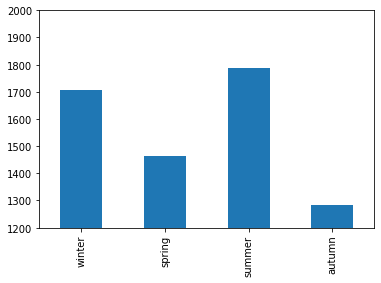

In [89]:
pd.Series(season_distances).plot.bar()
plt.ylim(1200,2000)

In [90]:
checkins_per_user = {k: len(v) for k,v in checkin_brightkite.groupby('user')}
active_users = [k for k, v in checkins_per_user.items() if v >= 150 ]

In [88]:
len(active_users)

3497